In [380]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from datetime import datetime as dt

FIGSIZE = (20, 6)

In [416]:
years = [i.name for i in os.scandir(f"inmet-data") if i.is_dir()]
location = "A801"

filenames = []
for year in years:
    filenames.extend(
        [
            f"{year}/{file.name}"
            for file in os.scandir(f"inmet-data/{year}")
            if location in file.name
        ]
    )

filenames.sort()

dfs = []
for f in filenames:
    df = pd.read_csv(f"inmet-data/{f}", delimiter=";", header=8, encoding="iso-8859-1")
    dfs.append(
        df.rename(
            columns={
                "HORA (UTC)": "Hora UTC",
                "DATA (YYYY-MM-DD)": "Data",
                "RADIACAO GLOBAL (Kj/m²)": "RADIACAO GLOBAL (KJ/m²)",
            }
        )
    )

raw_data = pd.concat(dfs).reset_index()
raw_data

,index,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,0,2006-09-24,00:00,0,"1011,7","1011,7","1011,2",-9999,"22,5",21,...,"22,4",21,"20,8",92.0,88.0,91.0,110.0,"8,3","3,7",NaN
1,1,2006-09-24,01:00,0,"1011,9","1011,9","1011,7",-9999,"22,7",21,...,"22,4","21,1",21,92.0,90.0,90.0,95.0,6,"3,3",NaN
2,2,2006-09-24,02:00,0,"1011,9","1012,1","1011,8",-9999,"22,6",21,...,"22,5","21,1",21,91.0,90.0,91.0,112.0,"6,1","3,8",NaN
3,3,2006-09-24,03:00,0,"1011,4",1012,"1011,4",-9999,"22,5","21,2",...,"22,5","21,2",21,92.0,91.0,92.0,102.0,"5,6","2,7",NaN
4,4,2006-09-24,04:00,0,"1011,1","1011,6","1011,1",-9999,"22,3","21,2",...,"22,3","21,2","21,1",93.0,92.0,93.0,123.0,"4,8","2,5",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156499,5107,2024/07/31,1900 UTC,0,1025,"1025,1","1024,8",964,"23,8","17,5",...,23,18,"16,8",72.0,65.0,68.0,NaN,NaN,NaN,NaN
156500,5108,2024/07/31,2000 UTC,0,"1024,9","1025,1","1024,9","408,2","22,6",17,...,"22,5","17,6","16,6",71.0,66.0,71.0,NaN,NaN,NaN,NaN
156501,5109,2024/07/31,2100 UTC,0,"1025,3","1025,3","1024,9","27,1","22,5","16,8",...,"22,3","17,2","16,4",72.0,69.0,70.0,NaN,NaN,NaN,NaN
156502,5110,2024/07/31,2200 UTC,0,"1025,6","1025,6","1025,3",0,"22,4","16,9",...,"22,3","17,2","16,4",72.0,69.0,71.0,NaN,NaN,NaN,NaN


In [417]:
cols = raw_data.columns

# treating hour data bc it's not super consistent
raw_data[cols[2]] = raw_data[cols[2]].apply(
    lambda s: ":".join([s[:2], s[2:4]]) if isinstance(s, str) and "UTC" in s else s
)
# same for dates
raw_data[cols[1]] = raw_data[cols[1]].apply(
    lambda s: s.replace("/", "-") if isinstance(s, str) else s
)


raw_data["datetime"] = pd.to_datetime(
    raw_data[cols[1]] + " " + raw_data[cols[2]], format="%Y-%m-%d %H:%M"
)


def parseToFloat(col):
    return (
        raw_data[col]
        .apply(lambda x: np.float64(x.replace(",", ".")) if (isinstance(x, str)) else x)
        .apply(lambda x: np.nan if x == -9999.0 else x)
    )


# global-radiation
raw_data["global-radiation"] = parseToFloat(cols[7])

# precipitation
raw_data["total-precipitation"] = parseToFloat(cols[3])

raw_data["relative-humidity"] = parseToFloat("UMIDADE RELATIVA DO AR, HORARIA (%)")

# temperature
raw_data["temperature-last-hour-max"] = parseToFloat(
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"
)
raw_data["temperature-last-hour-min"] = parseToFloat(
    "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"
)

# wind
raw_data["wind-speed"] = parseToFloat("VENTO, VELOCIDADE HORARIA (m/s)")
raw_data["wind-speed-max-gust"] = parseToFloat("VENTO, RAJADA MAXIMA (m/s)")

raw_data
# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.drop(columns=cols[:21]).set_index("datetime")
renamed_data["datetime"] = renamed_data.index
renamed_data

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,datetime
datetime,,,,,,,,
2006-09-24 00:00:00,NaN,0.0,91.0,22.8,22.4,3.7,8.3,2006-09-24 00:00:00
2006-09-24 01:00:00,NaN,0.0,90.0,22.8,22.4,3.3,6.0,2006-09-24 01:00:00
2006-09-24 02:00:00,NaN,0.0,91.0,22.7,22.5,3.8,6.1,2006-09-24 02:00:00
2006-09-24 03:00:00,NaN,0.0,92.0,22.7,22.5,2.7,5.6,2006-09-24 03:00:00
2006-09-24 04:00:00,NaN,0.0,93.0,22.5,22.3,2.5,4.8,2006-09-24 04:00:00
...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,964.0,0.0,68.0,23.9,23.0,NaN,NaN,2024-07-31 19:00:00
2024-07-31 20:00:00,408.2,0.0,71.0,23.8,22.5,NaN,NaN,2024-07-31 20:00:00
2024-07-31 21:00:00,27.1,0.0,70.0,22.6,22.3,NaN,NaN,2024-07-31 21:00:00


In [441]:
target = "global-radiation"
idx = "datetime"

df = renamed_data

by_day = (
    renamed_data.groupby([df.index.year, df.index.day_of_year]).mean().set_index(idx)
)

by_day = by_day.loc[by_day[target].notna()]
by_day[idx] = by_day.index
by_day[idx] = by_day[idx].apply(lambda d: d.replace(hour=0, minute=0, second=0))
by_day = by_day.set_index(idx)
by_day.head()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2006-09-24,680.200000,0.100000,84.416667,22.541667,21.837500,4.079167,9.795833
2006-09-25,520.430769,0.000000,71.958333,20.908333,20.333333,2.033333,5.708333
2006-09-26,556.330769,0.016667,74.208333,20.283333,19.554167,1.904167,4.904167
2006-09-27,1899.907692,0.000000,62.500000,21.454167,21.029167,5.304167,9.012500
2006-09-28,1948.461538,0.000000,73.454545,21.427273,21.013636,8.468182,13.004545


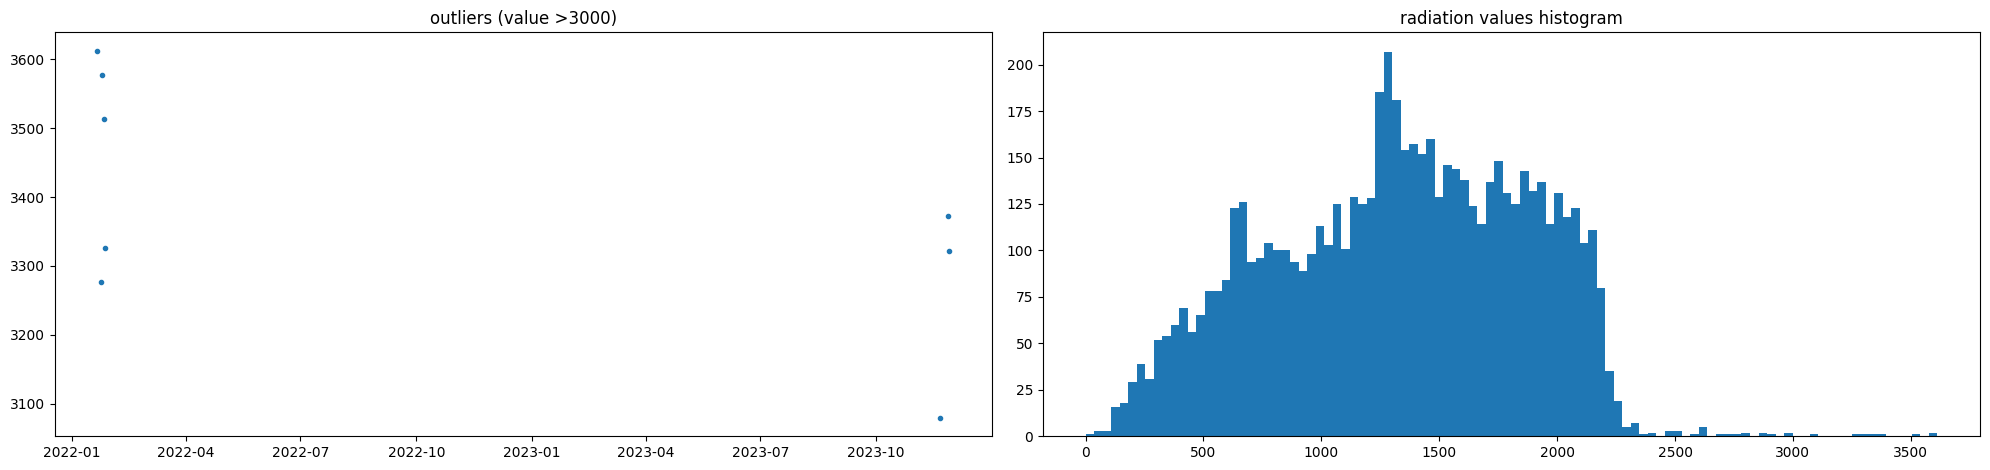

In [442]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
cap = 3000

ax[0].set_title(f"outliers (value >{cap})")
ax[0].plot(by_day.loc[by_day[target] > cap, target], ".")

ax[1].set_title("radiation values histogram")
ax[1].hist(by_day[target], 100)

plt.tight_layout()

by_day = by_day.loc[by_day[target] < cap]

'len(train) = 5330\nlen(test) = 252'

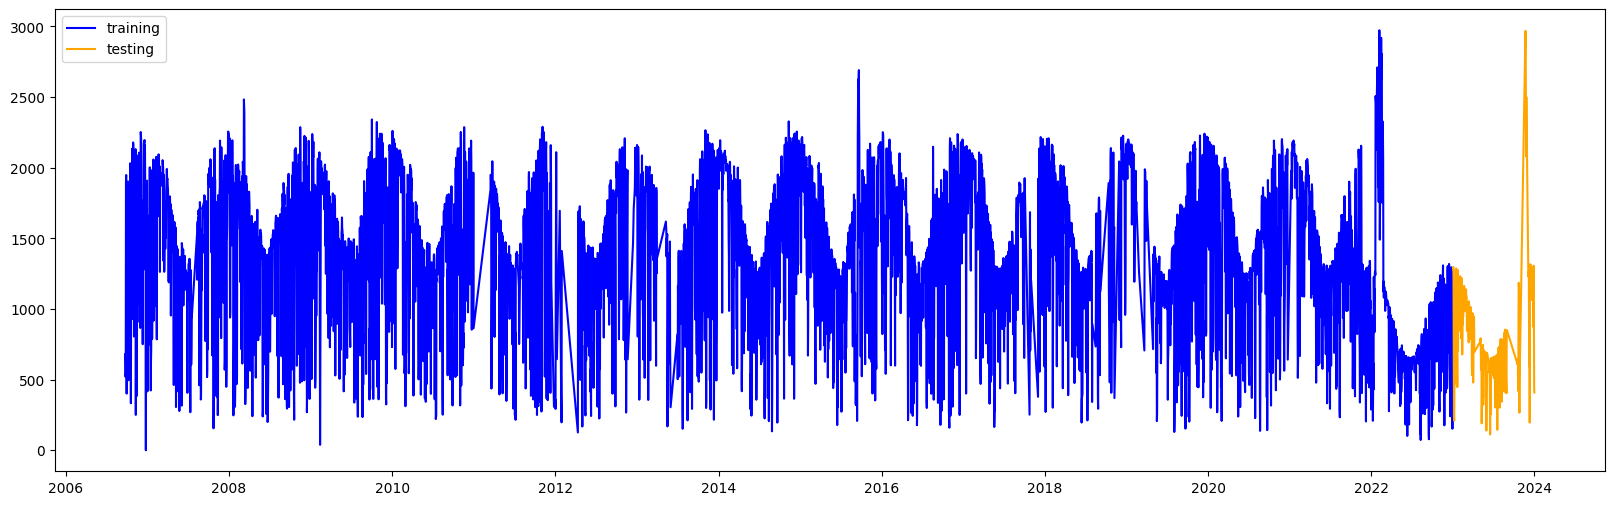

In [443]:
date_threshold, date_mask = "2023", "%Y"
date_upper_threshold = str(int(date_threshold) + 1)


def training_threshold(col):
    return col <= pd.to_datetime(date_threshold, format=date_mask)


def testing_treshold(col):
    return ~training_threshold(col) & (
        col <= pd.to_datetime(date_upper_threshold, format=date_mask)
    )


def split_datasets(df):
    return (
        df[training_threshold(df.index)].dropna(),
        df[testing_treshold(df.index)].dropna(),
    )


train, test = split_datasets(by_day)

plt.figure(figsize=FIGSIZE)
plt.plot(train[target], color="blue", label="training")
plt.plot(test[target], color="orange", label="testing")
plt.legend()

f"len(train) = {train[target].size}\nlen(test) = {test[target].size}"

In [444]:
window_size = 49


def make_rolling_window(df, window_size=window_size):
    return df.rolling(window=window_size).mean().copy()


def reset_time(df):
    df[idx] = df.index
    df[idx] = df[idx].apply(lambda t: t.replace(hour=0, minute=0, second=0))
    return df.set_index(idx)


train_rolling = make_rolling_window(train)
train_rolling = reset_time(train_rolling)

test_rolling = make_rolling_window(test)
test_rolling = reset_time(test_rolling)

In [445]:
fit_data = pd.DataFrame(dict(ds=train_rolling.index, y=train_rolling[target]))

from prophet import Prophet

reg = Prophet()
reg.fit(fit_data)

16:37:30 - cmdstanpy - INFO - Chain [1] start processing
16:37:31 - cmdstanpy - INFO - Chain [1] done processing


/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,7046,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.0,7046.0,7046.0,7046.000000
mean,2017-07-16 17:31:41.674709248,1149.891069,970.471626,1315.797509,1132.339140,1166.869263,-6.068221,-6.068221,-6.068221,-0.001543,-0.001543,-0.001543,-6.066678,-6.066678,-6.066678,0.0,0.0,0.0,1143.822848
min,2006-11-11 00:00:00,-0.370944,-534.060573,-78.301330,-186.455627,171.972098,-336.181262,-336.181262,-336.181262,-1.113785,-1.113785,-1.113785,-335.067476,-335.067476,-335.067476,0.0,0.0,0.0,-278.853755
25%,2012-05-01 06:00:00,909.096638,746.925816,1082.937177,909.096638,909.096638,-187.642300,-187.642300,-187.642300,-0.981824,-0.981824,-0.981824,-187.075354,-187.075354,-187.075354,0.0,0.0,0.0,916.156801
50%,2017-06-09 12:00:00,1401.750137,1101.426154,1436.991610,1401.750137,1401.750137,30.444340,30.444340,30.444340,-0.538502,-0.538502,-0.538502,30.881840,30.881840,30.881840,0.0,0.0,0.0,1269.208736
75%,2023-01-03 18:00:00,1432.254611,1334.330572,1669.943320,1432.254611,1432.254611,145.155682,145.155682,145.155682,1.584063,1.584063,1.584063,145.198469,145.198469,145.198469,0.0,0.0,0.0,1502.145154
max,2027-10-31 00:00:00,1488.341641,1596.558246,1935.988525,1488.341641,1488.341641,297.968796,297.968796,297.968796,1.639985,1.639985,1.639985,296.328811,296.328811,296.328811,0.0,0.0,0.0,1758.872153
std,NaN,435.289320,493.878772,471.871913,471.783752,400.598711,200.278083,200.278083,200.278083,1.086785,1.086785,1.086785,200.277514,200.277514,200.277514,0.0,0.0,0.0,481.133549


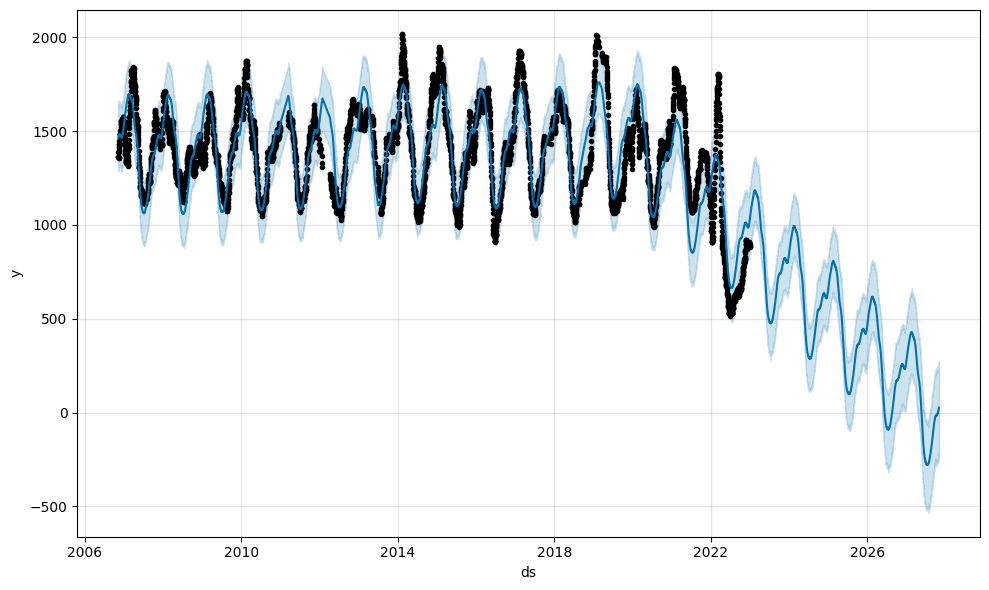

In [446]:
prediction_size = test_rolling.size
future = reg.make_future_dataframe(periods=prediction_size)
forecast = reg.predict(future)

reg.plot(forecast)
forecast.describe()

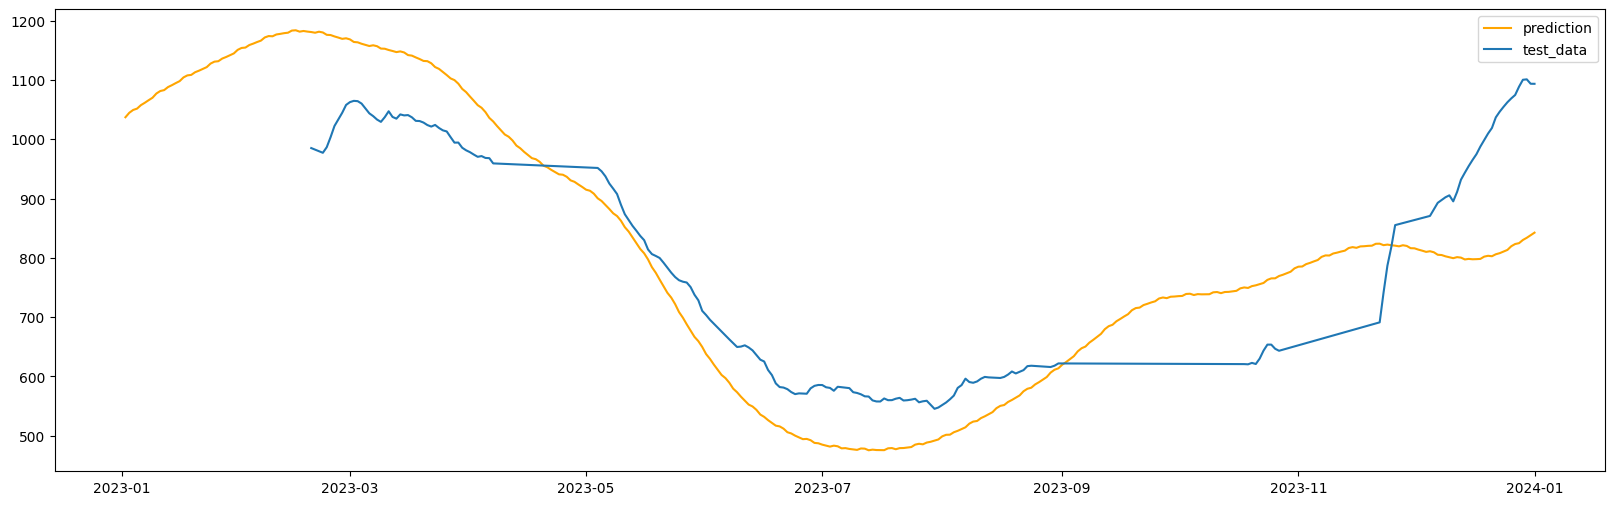

In [447]:
prediction = forecast.loc[testing_treshold(forecast.ds), ["ds", "yhat"]]

plt.figure(figsize=FIGSIZE)
plt.plot(prediction.ds, prediction.yhat, color="orange", label="prediction")
plt.plot(test_rolling[target], label="test_data")
plt.legend()

'predition error is 0.1213%'

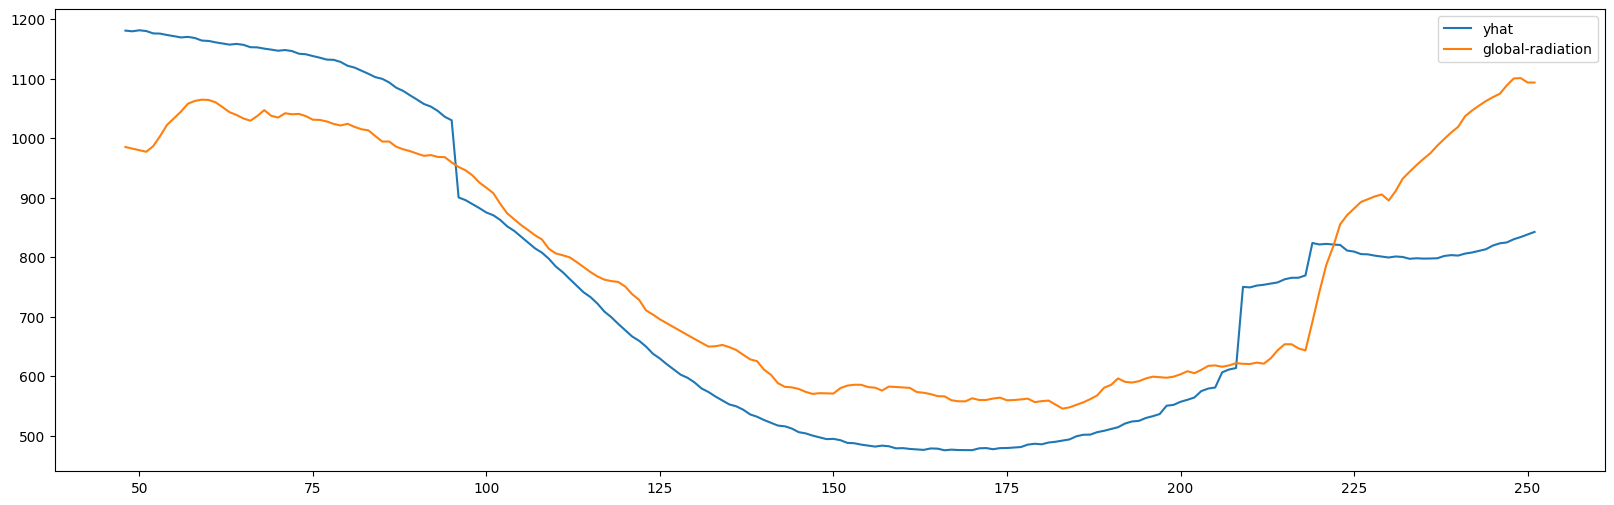

In [448]:
from sklearn.metrics import mean_absolute_percentage_error as mape

prediction_renamed = pd.DataFrame({idx: prediction.ds, "yhat": prediction.yhat})
comparison = test_rolling.merge(prediction_renamed, on=idx)
comparison = comparison.loc[(comparison.yhat.notna()) & (comparison[target].notna()),]

comparison[["yhat", target]].plot(figsize=FIGSIZE)

error = mape(comparison[target], comparison.yhat)
f"predition error is {error:.4f}%"

In [449]:
all_years = by_day.copy()
all_years["doy"] = by_day.index.day_of_year
all_years = make_rolling_window(all_years.groupby("doy").mean(), 28)

'historical error is 0.6299%'

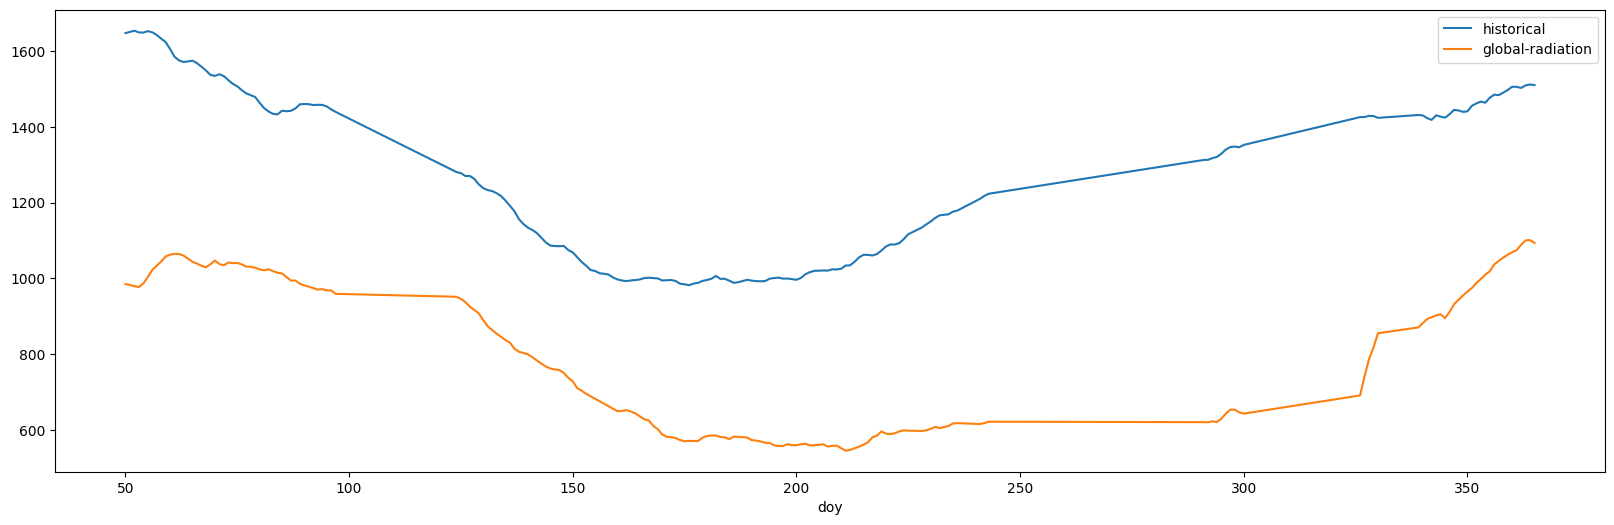

In [450]:
last_year = test_rolling.copy()
last_year["doy"] = last_year.index.day_of_year
last_year
last_year = last_year.groupby("doy").mean()

merged = all_years.merge(last_year[[target]], on="doy").rename(
    columns={f"{target}_x": "historical", f"{target}_y": target}
)

merged = merged.loc[
    (merged.historical.notna()) & (merged[target].notna()), ["historical", target]
]
merged.plot(figsize=FIGSIZE)

error_test = mape(merged[target], merged.historical)
f"historical error is {error_test:.4f}%"

In [451]:
xgb_df = make_rolling_window(by_day).copy()
xgb_df["lag1"] = (xgb_df.index - pd.DateOffset(years=1)).map(
    train_rolling[target].to_dict()
)
xgb_df.index - pd.DateOffset(years=1)
xgb_df["lag2"] = (xgb_df.index - pd.DateOffset(years=2)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag3"] = (xgb_df.index - pd.DateOffset(years=3)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag4"] = (xgb_df.index - pd.DateOffset(years=4)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag_history"] = xgb_df.index.day_of_year.map(all_years[target].to_dict())
xgb_df

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,lag1,lag2,lag3,lag4,lag_history
datetime,,,,,,,,,,,,
2006-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1345.630688
2006-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1346.764392
2006-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1344.452977
2006-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1341.364957
2006-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1340.600157
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,651.342950,0.014286,78.134083,23.460828,22.754904,NaN,NaN,NaN,564.464541,1094.435699,1056.756456,1023.655914
2024-07-28,632.810071,0.014286,78.266170,23.449235,22.743934,NaN,NaN,NaN,571.149150,1079.421414,1065.314776,1025.345053
2024-07-29,609.861941,0.014286,78.591170,23.356973,22.671032,NaN,NaN,NaN,579.356293,1084.143863,1076.924981,1033.947281


In [452]:
feats = []
for c in xgb_df.columns:
    if c == target:
        continue
    if abs(xgb_df.corr()[target][c]) >= 0.5:
        feats.append(c)
print(feats)

xgb_train = xgb_df.loc[training_threshold(xgb_df.index)]
xgb_test = xgb_df.loc[testing_treshold(xgb_df.index)]


def split_x_y_xgb(df, feats, target):
    return df.loc[df[target].notna(), feats], df.loc[df[target].notna(), target]


X_train, y_train = split_x_y_xgb(xgb_train, feats, target)
X_test, y_test = split_x_y_xgb(xgb_test, feats, target)

import xgboost as xgb

reg = xgb.XGBRegressor(
    base_score=1.0,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=100,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.1,
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

['lag1', 'lag2', 'lag3', 'lag4', 'lag_history']
[0]	validation_0-rmse:1263.55448	validation_1-rmse:694.77244
[100]	validation_0-rmse:131.28350	validation_1-rmse:510.65379
[107]	validation_0-rmse:129.61839	validation_1-rmse:509.82078


XGBRegressor(base_score=1.0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

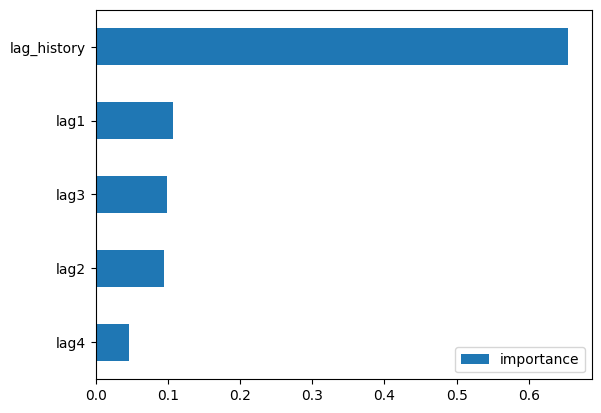

In [453]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
).sort_values("importance")

feature_importance.plot(kind="barh")

In [454]:
xgb_prediction = reg.predict(X_test)

prediction = pd.DataFrame(
    data=xgb_prediction, index=X_test.index, columns=["prediction"]
)
prediction = prediction.merge(y_test, left_index=True, right_index=True)

xgb error = 0.1298


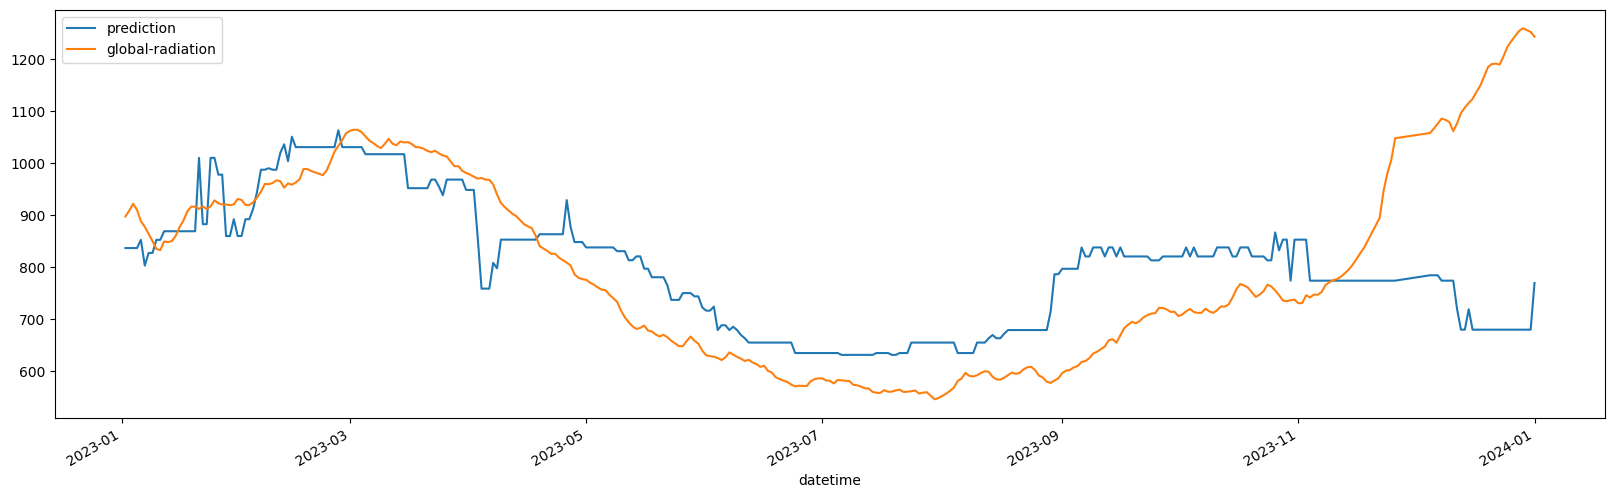

In [455]:
prediction.plot(figsize=FIGSIZE)

xgb_error = mape(prediction[target], prediction.prediction)
print(f"xgb error = {xgb_error:.4f}")